In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os
import re
import string
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
%matplotlib inline

In [2]:
emails = pd.read_csv('/Users/skylark/Desktop/Misc/DL and ML Practical Tutorials - Package/Project 6/emails.csv')
emails

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [5]:
emails.spam.value_counts(normalize=True)*100

0    76.117318
1    23.882682
Name: spam, dtype: float64

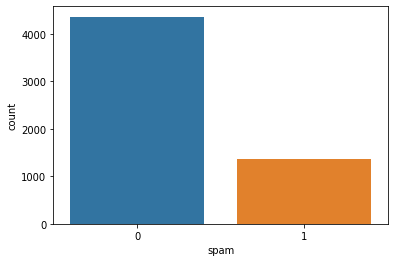

In [7]:
sn.countplot(emails['spam'])
plt.show()

In [107]:
pat1 = re.compile(r'[\w]{2,}[\s]')

In [112]:
emails['text_new'] = emails['text_new'].map(lambda x: ''.join(pat2.findall(x)).lower())

In [110]:
pat2 = re.compile(r'\D')

In [114]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [121]:
stop_words = stopwords.words()

In [122]:
lemmat = WordNetLemmatizer()

In [125]:
stemmer = PorterStemmer()

In [129]:
toknzr = TreebankWordTokenizer()

In [133]:
def build_stem(doc):
    stemmed_word = [stemmer.stem(word) for word in toknzr.tokenize(doc) if word not in stop_words]
    return stemmed_word

In [141]:
vectorizr = CountVectorizer(analyzer=build_stem)

In [143]:
cnt_vctr = vectorizr.fit_transform(emails.text_new)

In [145]:
cnt_vctr.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [146]:
vector_df = pd.DataFrame(cnt_vctr.toarray(), columns=vectorizr.get_feature_names())

In [156]:
columns = vector_df.sum()[vector_df.sum()>10].index

In [158]:
tf_idf = TfidfVectorizer(analyzer=build_stem, max_features=500)

In [159]:
tf_idf_vctr = tf_idf.fit_transform(emails.text_new)

In [161]:
tf_idf_vctr_df = pd.DataFrame(tf_idf_vctr.toarray(), columns=tf_idf.get_feature_names())

In [164]:
target = emails.spam

In [166]:
from sklearn.model_selection import train_test_split

In [167]:
train_x, test_x, train_y, test_y = train_test_split(tf_idf_vctr_df, target, test_size=0.3, random_state=42)

In [174]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

In [175]:
mnb_mod = MultinomialNB()
mnb_mod.fit(train_x, train_y)
mnb_mod.score(test_x, test_y)

0.9557882489819662

In [176]:
bnb_mod = BernoulliNB()
bnb_mod.fit(train_x, train_y)
bnb_mod.score(test_x, test_y)

0.900523560209424

In [177]:
gnb_mod = GaussianNB()
gnb_mod.fit(train_x, train_y)
gnb_mod.score(test_x, test_y)

0.9552065154159395

### neural network

In [201]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models, layers
from keras import callbacks

In [190]:
max_features = 2000
max_len = 500

In [181]:
tknzr = Tokenizer(num_words=2000)

In [183]:
tknzr.fit_on_texts(emails.text_new)

In [184]:
spam_data = tknzr.texts_to_sequences(emails.text_new)

In [191]:
spam_data = pad_sequences(spam_data, maxlen=max_len)

In [195]:
train_x_nn, test_x_nn, train_y_nn, test_y_nn = train_test_split(spam_data, target, test_size=0.3, random_state=100)

In [199]:
model = models.Sequential()

In [200]:
model.add(layers.Embedding(input_dim = max_features, output_dim=64, input_length = max_len))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LSTM(64))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 32)           12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 173,697
Trainable params: 173,697
Non-trainable params: 0
_________________________________________________________________


In [202]:
callback = [callbacks.ModelCheckpoint(filepath='/Users/skylark/Desktop/Misc/DL and ML Practical Tutorials - Package/Project 6/model.h5',monitor='val_loss'),
           callbacks.EarlyStopping(monitor='val_loss', patience=5),
           callbacks.ReduceLROnPlateau()]

In [203]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.fit(train_x_nn, train_y_nn, batch_size=128, epochs=20, validation_split=0.2, callbacks=callback)

Train on 3207 samples, validate on 802 samples
Epoch 1/20
3207/3207 [==============================] - 57s 18ms/step - loss: 0.3886 - acc: 0.8410 - val_loss: 0.1595 - val_acc: 0.9414
Epoch 2/20
3207/3207 [==============================] - 41s 13ms/step - loss: 0.0960 - acc: 0.9673 - val_loss: 0.0676 - val_acc: 0.9776
Epoch 3/20
3207/3207 [==============================] - 41s 13ms/step - loss: 0.0410 - acc: 0.9850 - val_loss: 0.1927 - val_acc: 0.9489
Epoch 4/20
3207/3207 [==============================] - 41s 13ms/step - loss: 0.0592 - acc: 0.9885 - val_loss: 0.0976 - val_acc: 0.9788
Epoch 5/20
3207/3207 [==============================] - 41s 13ms/step - loss: 0.0317 - acc: 0.9928 - val_loss: 0.0610 - val_acc: 0.9813
Epoch 6/20
3207/3207 [==============================] - 41s 13ms/step - loss: 0.0339 - acc: 0.9903 - val_loss: 0.1606 - val_acc: 0.9489
Epoch 7/20
3207/3207 [==============================] - 1098s 342ms/step - loss: 0.0140 - acc: 0.9956 - val_loss: 0.1006 - val_acc: 0.972

In [204]:
model.evaluate(test_x_nn, test_y_nn)

1719/1719 [==============================] - 7s 4ms/step


[0.1101987840842557, 0.9749854803085327]